In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[3]:


#!/usr/bin/env python

from __future__ import division, print_function

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import bilby

outdir = 'outdir'
label = 'LISAstatic_roq_PE'

start_time = datetime.now()

In [2]:
scale_factor = 1.0

# Load in the pieces for the linear part of the ROQ. Note you will need to
# adjust the filenames here to the correct paths on your machine
basis_matrix_linear = np.load("B_linear.npy").T
freq_nodes_linear = np.load("fnodes_linear.npy") * scale_factor

# Load in the pieces for the quadratic part of the ROQ
basis_matrix_quadratic = np.load("B_quadratic.npy").T
freq_nodes_quadratic = np.load("fnodes_quadratic.npy") * scale_factor

# Load the parameters describing the valid parameters for the basis.
# params = np.genfromtxt("/Users/hxc/Downloads/ROQ_data-master/IMRPhenomPv2/4s/params.dat", names=True)
params = np.genfromtxt("params.dat", names=True)
params['flow'] *= scale_factor
params['fhigh'] *= scale_factor
params['seglen'] /= scale_factor
params['chirpmassmin'] /= scale_factor
params['chirpmassmax'] /= scale_factor
params['compmin'] /= scale_factor



/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


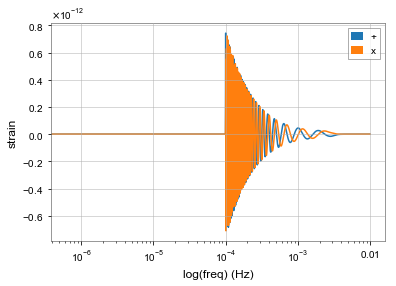

In [3]:
# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(88170232)

duration = 1638400 / scale_factor   # deltaF = 1.0e-6
sampling_frequency = 2.0e-2 * scale_factor  # fmax = 1.0e-2

injection_parameters = dict(
    mass_1=3.6e6, mass_2=2.9e6, a_1=0.4, a_2=0.3, tilt_1=0.0, tilt_2=0.0,
    phi_12=1.7, phi_jl=0.3, luminosity_distance=1000, theta_jn=0.4, psi=0.659,
    phase=1.3, geocent_time=1126259642.413, ra=1.375, dec=-1.2108)

waveform_arguments = dict(waveform_approximant='IMRPhenomPv2',
                          reference_frequency=1.0e-4,
                          minimum_frequency=1.0e-4)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    start_time=injection_parameters['geocent_time'] - duration)


freq = waveform_generator.frequency_array
hplus = waveform_generator.frequency_domain_strain(injection_parameters)['plus']
hcross = waveform_generator.frequency_domain_strain(injection_parameters)['cross']
plt.plot(freq, hplus,label='+')
plt.plot(freq, hcross,label='x')
plt.xlabel('log(freq) (Hz)')
plt.ylabel('strain')
plt.legend()
plt.xscale('log')
plt.savefig('LISA_IMRPhenomPv2_waveform.png', dpi=200)

In [4]:
LISA_static = bilby.gw.detector.Interferometer(
    power_spectral_density=bilby.gw.detector.PowerSpectralDensity(
        psd_file='lisa_psd.txt'),
    name='LISA_static', length=2.5e6,
    minimum_frequency=1.0e-4, \
    maximum_frequency=max(waveform_generator.frequency_array),
    latitude=-31.34, longitude=115.91,
    elevation=0., xarm_azimuth=2., yarm_azimuth=125.)

# Set up new detector to InterferomerList
interferometers = bilby.gw.detector.InterferometerList([])

# append the new detector to the list 
interferometer = interferometers.append(LISA_static)


for interferometer in interferometers:
    interferometer.set_strain_data_from_zero_noise(
        sampling_frequency=sampling_frequency, duration=duration,
     start_time=injection_parameters['geocent_time'] - duration)
    interferometer.inject_signal(
        parameters=injection_parameters, waveform_generator=waveform_generator)
    
# make ROQ waveform generator
search_waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    start_time=injection_parameters['geocent_time'] - duration,
    frequency_domain_source_model=bilby.gw.source.binary_black_hole_roq,
    waveform_arguments=dict(
        frequency_nodes_linear=freq_nodes_linear,
        frequency_nodes_quadratic=freq_nodes_quadratic,
        reference_frequency=1.0e-4 * scale_factor, waveform_approximant='IMRPhenomPv2'),
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters)

14:48 bilby INFO    : Injected signal in LISA_static:
14:48 bilby INFO    :   optimal SNR = 39196.56
14:48 bilby INFO    :   matched filter SNR = 39196.56+0.00j
14:48 bilby INFO    :   mass_1 = 3600000.0
14:48 bilby INFO    :   mass_2 = 2900000.0
14:48 bilby INFO    :   a_1 = 0.4
14:48 bilby INFO    :   a_2 = 0.3
14:48 bilby INFO    :   tilt_1 = 0.0
14:48 bilby INFO    :   tilt_2 = 0.0
14:48 bilby INFO    :   phi_12 = 1.7
14:48 bilby INFO    :   phi_jl = 0.3
14:48 bilby INFO    :   luminosity_distance = 1000
14:48 bilby INFO    :   theta_jn = 0.4
14:48 bilby INFO    :   psi = 0.659
14:48 bilby INFO    :   phase = 1.3
14:48 bilby INFO    :   geocent_time = 1126259642.413
14:48 bilby INFO    :   ra = 1.375
14:48 bilby INFO    :   dec = -1.2108


In [5]:
# create the priors
priors = dict()
for key in ['a_1', 'a_2', 'tilt_1', 'tilt_2', 'theta_jn', 'phase', 'psi', 'ra',
            'dec', 'phi_12', 'phi_jl', 'luminosity_distance']:
    priors[key] = injection_parameters[key]
    
priors['mass_1'] = bilby.core.prior.Uniform(2.0e6, 5.0e6, name='mass_1')
priors['mass_2'] = bilby.core.prior.Uniform(2.0e6, 5.0e6, name='mass_2')
priors['geocent_time'] = bilby.core.prior.Uniform(
    injection_parameters['geocent_time'] - 0.1,
    injection_parameters['geocent_time'] + 0.1, latex_label='$t_c$', unit='s')


In [6]:
# print(interferometer.frequency_mask[0:10])
# print(interferometer.power_spectral_density_array[0:4])

In [7]:
likelihood = bilby.gw.likelihood.ROQGravitationalWaveTransient(
    interferometers=interferometers, waveform_generator=search_waveform_generator,
    linear_matrix=basis_matrix_linear, quadratic_matrix=basis_matrix_quadratic,
    priors=priors, roq_params=params)


# write the weights to file so they can be loaded multiple times
likelihood.save_weights('weights.json')

# remove the basis matrices as these are big for longer bases
del basis_matrix_linear, basis_matrix_quadratic

# load the weights from the file
likelihood = bilby.gw.likelihood.ROQGravitationalWaveTransient(
    interferometers=interferometers, waveform_generator=search_waveform_generator,
    weights='weights.json.npz', priors=priors)
# print(likelihood.weights)
# print(np.sum(likelihood.weights))

14:48 bilby INFO    : ROQ time-step = 7.763846201440538
14:48 bilby INFO    : Using 11 ROQ time samples
14:48 bilby INFO    : Check ROQ params with roq_scale_factor=1
14:48 bilby WARNING : Unable to check ROQ parameter bounds: priors not understood
14:48 bilby INFO    : Building ROQ weights for LISA_static with 16221 frequencies between 0.00010009765625000001 and 0.01.
14:48 bilby INFO    : Finished building weights for LISA_static
14:48 bilby INFO    : Saving ROQ weights to weights.json.npz
14:48 bilby INFO    : Loading ROQ weights from weights.json.npz


14:48 bilby INFO    : Running for label 'LISAstatic_roq_PE', output will be saved to 'outdir'
14:48 bilby INFO    : Using LAL version Branch: None;Tag: lal-v6.20.2;Id: 3a24fdfad6684befecfedd7ed5309f560d166be0;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
14:48 bilby INFO    : Search parameters:
14:48 bilby INFO    :   mass_1 = Uniform(minimum=2000000.0, maximum=5000000.0, name='mass_1', latex_label='$m_1$', unit=None, boundary=None)
14:48 bilby INFO    :   mass_2 = Uniform(minimum=2000000.0, maximum=5000000.0, name='mass_2', latex_label='$m_2$', unit=None, boundary=None)
14:48 bilby INFO    :   geocent_time = Uniform(minimum=1126259642.3130002, maximum=1126259642.513, name=None, latex_label='$t_c$', unit='s', boundary=None)
14:48 bilby INFO    :   a_1 = 0.4
14:48 bilby INFO    :   a_2 = 0.3
14:48 bilby INFO    :   tilt_1 = 0.0
14:48 bilby INFO    :   tilt_2 = 0.0
14:48 bilby INFO    :   theta_jn = 0.4
14:48 bilby INFO    :   phase = 

0it [00:00, ?it/s]

14:48 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 512, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 307, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1c2051eba8>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
14:48 bilby INFO    : Checkpoint every n_check_point = 400000
14:48 bilby INFO    : Using dynesty version 1.0.0
14:48 bilby INFO    : Using the bilby-implemented rwalk sample 

4177it [15:32,  2.52it/s, bound:1944 nc:299 ncall:800806 eff:0.5% logz-ratio=765997950.54+/-0.39 dlogz:inf>0.10]

15:03 bilby INFO    : Writing checkpoint file outdir/LISAstatic_roq_PE_resume.pickle


/anaconda3/lib/python3.7/site-packages/dynesty/plotting.py:661: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim([0., max(y0) * 1.05])


8090it [38:42,  3.07it/s, bound:4653 nc:288 ncall:2001089 eff:0.4% logz-ratio=768183367.35+/-nan dlogz:1349.819>0.10]   

15:27 bilby INFO    : Writing checkpoint file outdir/LISAstatic_roq_PE_resume.pickle


/anaconda3/lib/python3.7/site-packages/dynesty/utils.py:135: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")
/anaconda3/lib/python3.7/site-packages/dynesty/utils.py:135: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")


12573it [1:09:50,  2.23it/s, bound:8921 nc:346 ncall:3601388 eff:0.3% logz-ratio=768184730.95+/-nan dlogz:12.539>0.10] 

15:58 bilby INFO    : Writing checkpoint file outdir/LISAstatic_roq_PE_resume.pickle


/anaconda3/lib/python3.7/site-packages/dynesty/utils.py:135: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")
/anaconda3/lib/python3.7/site-packages/dynesty/utils.py:135: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")


15831it [2:38:23,  2.23it/s, bound:12179 nc:369 ncall:4832344 eff:0.3% logz-ratio=768184739.49+/-1.84 dlogz:0.100>0.10] 

17:26 bilby INFO    : Writing checkpoint file outdir/LISAstatic_roq_PE_resume.pickle


/anaconda3/lib/python3.7/site-packages/dynesty/utils.py:135: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")
/anaconda3/lib/python3.7/site-packages/dynesty/utils.py:135: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")


/anaconda3/lib/python3.7/site-packages/dynesty/utils.py:135: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")
17:26 bilby INFO    : Sampling time: 2:38:23.030627
17:26 bilby INFO    : Summary of results:
nsamples: 16343
log_noise_evidence: -768185219.366
log_evidence: -479.794 +/-  0.470
log_bayes_factor: 768184739.572 +/-  0.470



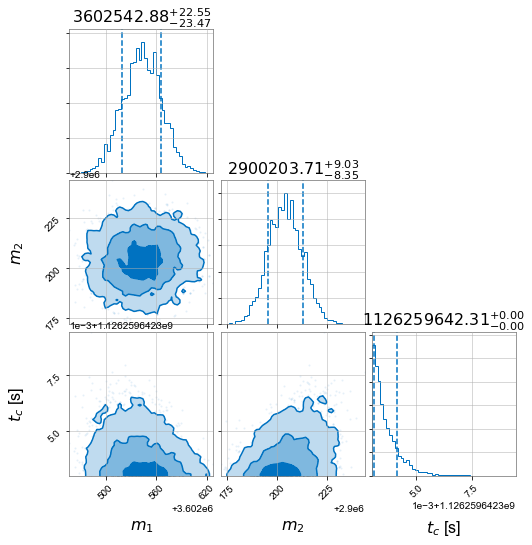

In [8]:
result = bilby.run_sampler(
    likelihood=likelihood, priors=priors, sampler='dynesty', npoints=512,
    injection_parameters=injection_parameters, outdir = outdir, label=label)

# Make a corner plot.
result.plot_corner()


In [9]:
end_time = datetime.now()
running_time = end_time - start_time
print(running_time)

2:38:34.384116
